<a href="https://colab.research.google.com/github/kellybertozzi/Coffee-Predictor/blob/main/Coffee_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we read the data from the file, and put it into various feature groups, then creates input features and targets

In [ ]:
pip requirements.txt

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_excel("Actual Coffee Recommender Data.xlsx")

# Define feature groups
temperature_features = ['iced', 'hot']  # Binary features
preference_features = ['sweetness', 'creaminess']  # Numerical features
flavor_columns = [col for col in data.columns if col not in ['coffee_type'] + temperature_features + preference_features]

# Coffee type scale
coffee_scale = {
    "espresso": 0,
    "americano": 1,
    "cold_brew": 2,
    "coffee": 3,
    "macchiato": 4,
    "cappuccino": 5,
    "latte": 6,
    "frozen_coffee": 7
}

# Clean coffee_type and verify all types exist
data['coffee_type'] = data['coffee_type'].str.strip()
missing_types = set(data['coffee_type'].unique()) - set(coffee_scale.keys())
if missing_types:
    raise ValueError(f"Missing coffee types in scale: {missing_types}")

# Create input features and targets
X_temp = data[temperature_features]
X_pref = data[preference_features]
X_flavor = data[flavor_columns]
X = pd.concat([X_temp, X_pref, X_flavor], axis=1)

# Targets
y_coffee = data['coffee_type'].map(coffee_scale)  # Coffee type classification
y_flavor = data[flavor_columns]  # Multi-label flavor prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Data Visualization (Graphs)

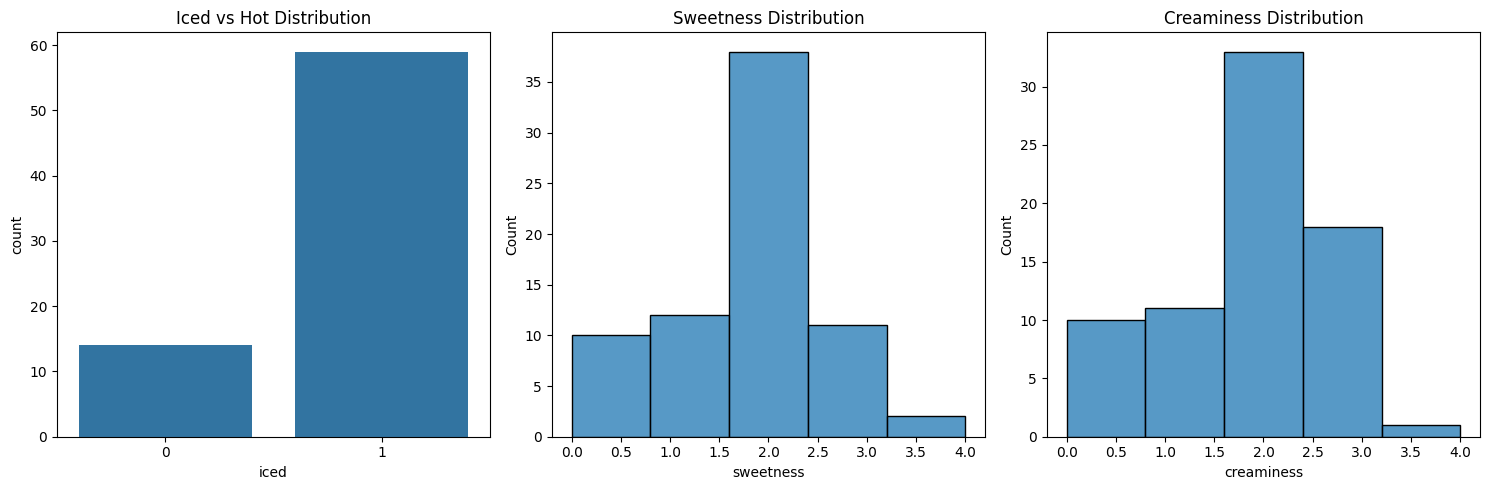

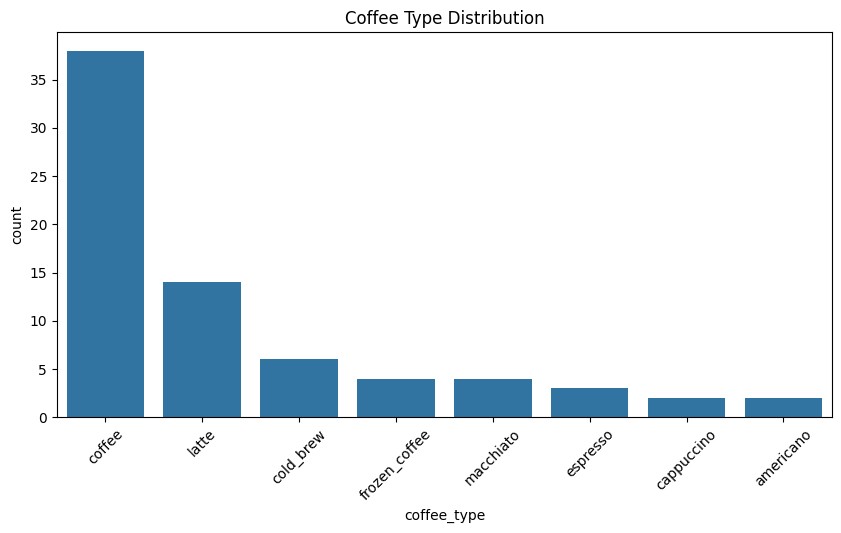

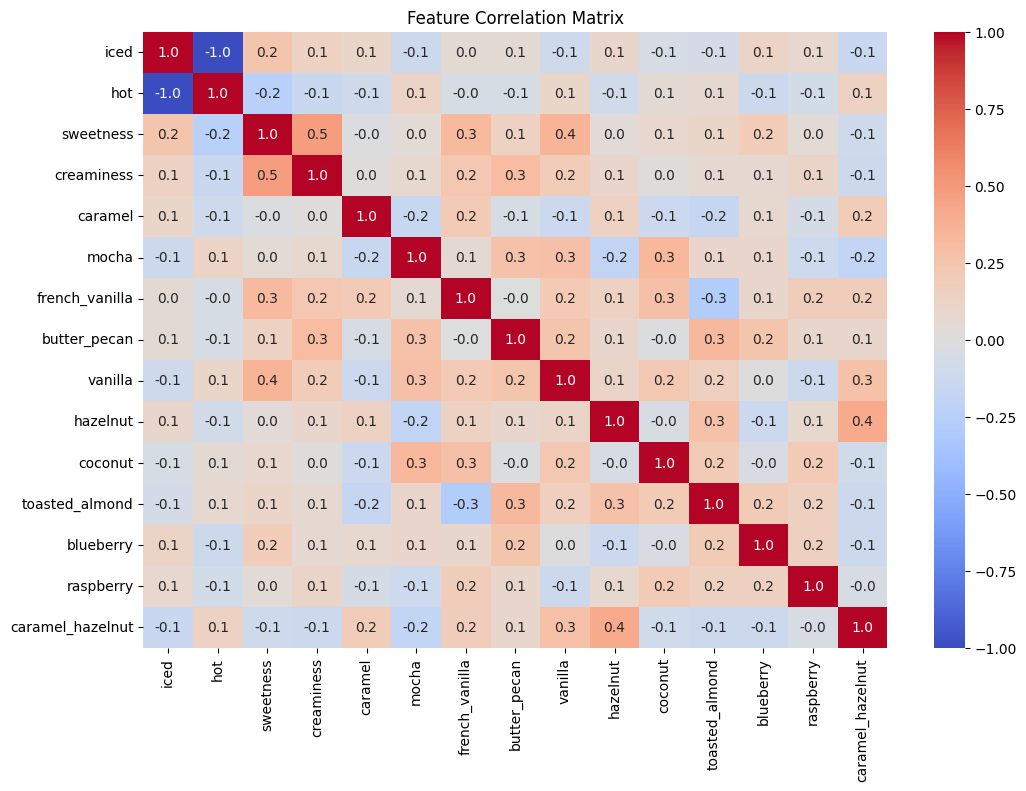

In [5]:
# Feature distributions
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(data=data, x='iced')
plt.title('Iced vs Hot Distribution')

plt.subplot(1, 3, 2)
sns.histplot(data['sweetness'], bins=5)
plt.title('Sweetness Distribution')

plt.subplot(1, 3, 3)
sns.histplot(data['creaminess'], bins=5)
plt.title('Creaminess Distribution')
plt.tight_layout()
plt.show()

# Target distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='coffee_type', order=data['coffee_type'].value_counts().index)
plt.title('Coffee Type Distribution')
plt.xticks(rotation=45)
plt.show()

# Feature correlations
corr_matrix = X.iloc[:, :15].corr()  # First 15 features are displayed for ease of reading
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

The neural network itself

In [6]:
class CoffeeRecommender(nn.Module):
    def __init__(self, num_temp_features, num_pref_features, num_flavors, num_coffee_types):
        super().__init__()
        # Stores feature dimensions as attributes
        self.num_temp_features = num_temp_features
        self.num_pref_features = num_pref_features
        self.num_flavors = num_flavors
        self.num_coffee_types = num_coffee_types

        # Temperature
        self.temp_fc = nn.Sequential(
            nn.Linear(num_temp_features, 8),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Preference
        self.pref_fc = nn.Sequential(
            nn.Linear(num_pref_features, 8),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Flavor
        self.flavor_fc = nn.Sequential(
            nn.Linear(num_flavors, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Combined layers
        self.combined = nn.Sequential(
            nn.Linear(8 + 8 + 32, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Output heads
        self.coffee_head = nn.Linear(32, num_coffee_types)
        self.flavor_head = nn.Linear(32, num_flavors)

    def forward(self, x):
        # Split input into feature groups
        temp = x[:, :self.num_temp_features]
        pref = x[:, self.num_temp_features:self.num_temp_features + self.num_pref_features]
        flavors = x[:, self.num_temp_features + self.num_pref_features:]

        # Process each feature group
        temp_out = self.temp_fc(temp)
        pref_out = self.pref_fc(pref)
        flavor_out = self.flavor_fc(flavors)

        # Combine features
        combined = torch.cat([temp_out, pref_out, flavor_out], dim=1)
        features = self.combined(combined)

        # Generate outputs
        coffee_logits = F.log_softmax(self.coffee_head(features), dim=1)
        flavor_probs = torch.sigmoid(self.flavor_head(features))

        return coffee_logits, flavor_probs

Begins training the model

In [7]:
# Split data
X_train, X_temp, y_coffee_train, y_coffee_temp, y_flavor_train, y_flavor_temp = train_test_split(
    X, y_coffee, y_flavor, test_size=0.3, random_state=42)
X_val, X_test, y_coffee_val, y_coffee_test, y_flavor_val, y_flavor_test = train_test_split(
    X_temp, y_coffee_temp, y_flavor_temp, test_size=0.5, random_state=42)

# Print it (to verify training is going right)
print("Data Split Sizes: ")
print(f"Training Set: {len(X_train)} samples")
print(f"Validation Set: {len(X_val)} samples")
print(f"Test Set: {len(X_test)} samples\n")

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_coffee_train_tensor = torch.LongTensor(y_coffee_train.values)
y_flavor_train_tensor = torch.FloatTensor(y_flavor_train.values)

X_val_tensor = torch.FloatTensor(X_val.values)
y_coffee_val_tensor = torch.LongTensor(y_coffee_val.values)
y_flavor_val_tensor = torch.FloatTensor(y_flavor_val.values)

X_test_tensor = torch.FloatTensor(X_test.values)
y_coffee_test_tensor = torch.LongTensor(y_coffee_test.values)
y_flavor_test_tensor = torch.FloatTensor(y_flavor_test.values)

# Initialize model
model = CoffeeRecommender(
    num_temp_features=len(temperature_features),
    num_pref_features=len(preference_features),
    num_flavors=len(flavor_columns),
    num_coffee_types=len(coffee_scale)
)

# Loss and optimizer functions
criterion_coffee = nn.NLLLoss()
criterion_flavor = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

Data Split Sizes: 
Training Set: 51 samples
Validation Set: 11 samples
Test Set: 11 samples



Weights the inputs, as classes like coffee appear a lot, but not so much other classes such as an americano

In [8]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
classes = np.array(sorted(coffee_scale.keys()))
class_weights = compute_class_weight('balanced', classes=classes, y=data['coffee_type'])

# Convert to tensor
class_weights_tensor = torch.FloatTensor(class_weights)

# Print class weights for verification
print("Class weights:")
for coffee_type, weight in zip(classes, class_weights):
    print(f"{coffee_type}: {weight:.2f}")

Class weights:
americano: 4.56
cappuccino: 4.56
coffee: 0.24
cold_brew: 1.52
espresso: 3.04
frozen_coffee: 2.28
latte: 0.65
macchiato: 2.28


Loss function

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# efine your coffee type classification loss, with class weighting
def get_coffee_loss_function(data, coffee_scale):
    # Calculate class weights (again)
    unique_classes = np.sort(data['coffee_type'].unique())
    class_weights = compute_class_weight(
        'balanced',
        classes=unique_classes,
        y=data['coffee_type']
    )

    # Order weights according to coffee_scale
    ordered_weights = np.zeros(len(coffee_scale))
    for coffee_type, weight in zip(unique_classes, class_weights):
        ordered_weights[coffee_scale[coffee_type]] = weight

    # Convert to tensor and return NLLLoss
    weights_tensor = torch.FloatTensor(ordered_weights)
    return nn.NLLLoss(weight=weights_tensor)

# Define flavor prediction loss (multi-label binary classification)
flavor_loss_function = nn.BCELoss()  # Binary Cross-Entropy

# Combined loss function
def combined_loss(coffee_logits, coffee_targets,
                 flavor_probs, flavor_targets,
                 coffee_criterion, flavor_criterion,
                 alpha=0.5):
    """
    alpha: weight between coffee and flavor losses (0.5 = equal importance)
    """
    coffee_loss = coffee_criterion(coffee_logits, coffee_targets)
    flavor_loss = flavor_criterion(flavor_probs, flavor_targets)
    return alpha * coffee_loss + (1 - alpha) * flavor_loss

Training the model

In [10]:
# Initialize loss functions
coffee_criterion = get_coffee_loss_function(data, coffee_scale)
flavor_criterion = flavor_loss_function

# Training parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
alpha = 0.7  # This gives more weight to coffee classification

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    coffee_logits, flavor_probs = model(X_train_tensor)

    # Calculate loss
    loss = combined_loss(
        coffee_logits, y_coffee_train_tensor,
        flavor_probs, y_flavor_train_tensor,
        coffee_criterion, flavor_criterion,
        alpha=alpha
    )

    # Backward pass
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_coffee_logits, val_flavor_probs = model(X_val_tensor)
        val_loss = combined_loss(
            val_coffee_logits, y_coffee_val_tensor,
            val_flavor_probs, y_flavor_val_tensor,
            coffee_criterion, flavor_criterion,
            alpha=alpha
        )

    # Print progress to verify
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")
        print(f"Coffee Loss: {coffee_criterion(coffee_logits, y_coffee_train_tensor).item():.4f}")
        print(f"Flavor Loss: {flavor_criterion(flavor_probs, y_flavor_train_tensor).item():.4f}")
        print("-----")

Epoch 10/100
Train Loss: 1.6433 | Val Loss: 1.6705
Coffee Loss: 2.0577
Flavor Loss: 0.6764
-----
Epoch 20/100
Train Loss: 1.6222 | Val Loss: 1.6935
Coffee Loss: 2.0350
Flavor Loss: 0.6590
-----
Epoch 30/100
Train Loss: 1.5913 | Val Loss: 1.7224
Coffee Loss: 2.0004
Flavor Loss: 0.6368
-----
Epoch 40/100
Train Loss: 1.5595 | Val Loss: 1.7641
Coffee Loss: 1.9694
Flavor Loss: 0.6031
-----
Epoch 50/100
Train Loss: 1.5229 | Val Loss: 1.8157
Coffee Loss: 1.9351
Flavor Loss: 0.5613
-----
Epoch 60/100
Train Loss: 1.4571 | Val Loss: 1.8624
Coffee Loss: 1.8575
Flavor Loss: 0.5227
-----
Epoch 70/100
Train Loss: 1.2820 | Val Loss: 1.9072
Coffee Loss: 1.6241
Flavor Loss: 0.4836
-----
Epoch 80/100
Train Loss: 1.2625 | Val Loss: 1.9720
Coffee Loss: 1.6143
Flavor Loss: 0.4417
-----
Epoch 90/100
Train Loss: 1.0311 | Val Loss: 2.0993
Coffee Loss: 1.3008
Flavor Loss: 0.4019
-----
Epoch 100/100
Train Loss: 1.0378 | Val Loss: 2.2627
Coffee Loss: 1.3147
Flavor Loss: 0.3919
-----


Hyperparameter tuning

Using device: cpu

=== Training with LR=0.1 ===

=== Training with LR=0.01 ===

=== Training with LR=0.001 ===

=== Training with LR=0.0001 ===


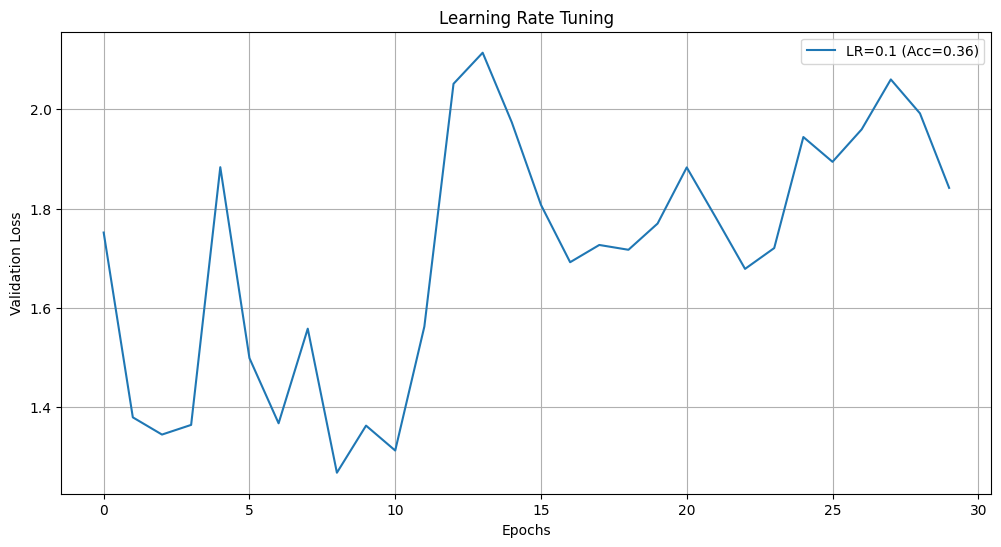

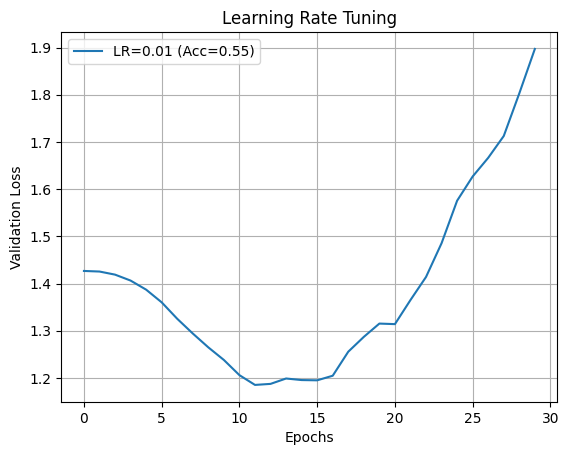

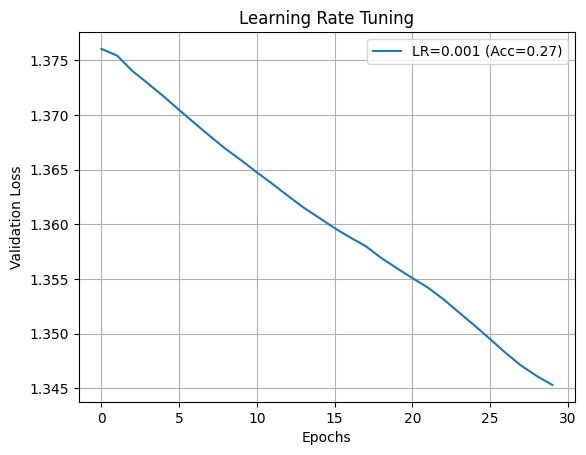

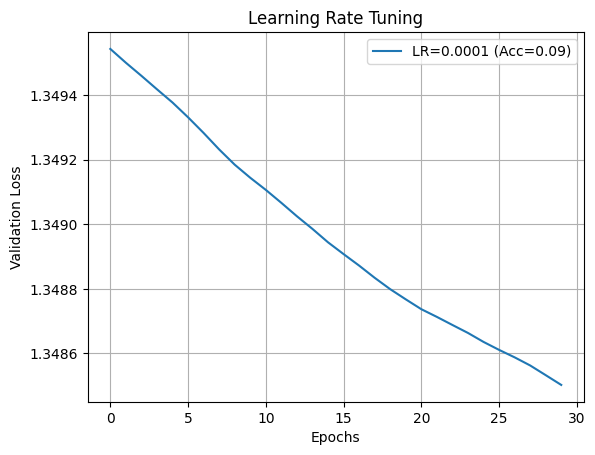


Best learning rate: 0.01
Validation accuracy at best LR: 0.55


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Define whether using GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move data to device (GPU/CPU)
X_train_tensor = X_train_tensor.to(device)
y_coffee_train_tensor = y_coffee_train_tensor.to(device)
y_flavor_train_tensor = y_flavor_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_coffee_val_tensor = y_coffee_val_tensor.to(device)
y_flavor_val_tensor = y_flavor_val_tensor.to(device)

# Learning Rate Tuning with device handling
learning_rates = [0.1, 0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    print(f"\n=== Training with LR={lr} ===")

    # Reinitializes model and move to device
    model = CoffeeRecommender(
        num_temp_features=len(temperature_features),
        num_pref_features=len(preference_features),
        num_flavors=len(flavor_columns),
        num_coffee_types=len(coffee_scale)
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    for epoch in range(30):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        coffee_logits, flavor_probs = model(X_train_tensor)

        # Calculate loss
        loss = combined_loss(
            coffee_logits, y_coffee_train_tensor,
            flavor_probs, y_flavor_train_tensor,
            coffee_criterion, flavor_criterion
        )

        # Backward pass
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_coffee_logits, val_flavor_probs = model(X_val_tensor)
            val_loss = combined_loss(
                val_coffee_logits, y_coffee_val_tensor,
                val_flavor_probs, y_flavor_val_tensor,
                coffee_criterion, flavor_criterion
            )
            val_losses.append(val_loss.item())

    results[lr] = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'final_val_accuracy': accuracy_score(
            y_coffee_val_tensor.cpu().numpy(),
            torch.argmax(val_coffee_logits, dim=1).cpu().numpy()
        )
    }

# Output results
plt.figure(figsize=(12, 6))
for lr, data in results.items():
    plt.plot(data['val_loss'], label=f'LR={lr} (Acc={data["final_val_accuracy"]:.2f})')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Learning Rate Tuning')
    plt.legend()
    plt.grid(True)
    plt.show()

# Print the best learning rate
best_lr = min(results, key=lambda x: min(results[x]['val_loss']))
print(f"\nBest learning rate: {best_lr}")
print(f"Validation accuracy at best LR: {results[best_lr]['final_val_accuracy']:.2f}")

Learning urve

In [12]:
# Modified training funt
def train_with_subset(model, subset_size, X_full, y_coffee_full, y_flavor_full):
    """Trains model on a random subset of data"""
    # Ensure subset_size doesn't exceed available samples
    num_samples = X_full.shape[0]
    subset_size = min(subset_size, num_samples)

    # Get random indices
    indices = np.random.choice(num_samples, subset_size, replace=False)
    indices = torch.LongTensor(indices).to(device)

    # Create subset
    X_subset = X_full[indices]
    y_coffee_subset = y_coffee_full[indices]
    y_flavor_subset = y_flavor_full[indices]

    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = [], []

    for epoch in range(30):
        model.train()
        optimizer.zero_grad()
        coffee_logits, flavor_probs = model(X_subset)
        loss = combined_loss(coffee_logits, y_coffee_subset,
                           flavor_probs, y_flavor_subset,
                           coffee_criterion, flavor_criterion)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_coffee_logits, val_flavor_probs = model(X_val_tensor)
            val_loss = combined_loss(val_coffee_logits, y_coffee_val_tensor,
                                   val_flavor_probs, y_flavor_val_tensor,
                                   coffee_criterion, flavor_criterion)
            val_losses.append(val_loss.item())

    return min(val_losses)

In [13]:
# Define subset sizes - make sure they're smaller than your dataset
subset_sizes = [5, 10, 20, 30, 40, 50, 51]  # For 61 total examples
results = []

for size in subset_sizes:
    print(f"Training with {size}/{len(X_train_tensor)} samples...")
    model = CoffeeRecommender(
        num_temp_features=len(temperature_features),
        num_pref_features=len(preference_features),
        num_flavors=len(flavor_columns),
        num_coffee_types=len(coffee_scale)
    ).to(device)

    val_loss = train_with_subset(model, size,
                               X_train_tensor,
                               y_coffee_train_tensor,
                               y_flavor_train_tensor)
    results.append({'size': size, 'val_loss': val_loss})

Training with 5/51 samples...
Training with 10/51 samples...
Training with 20/51 samples...
Training with 30/51 samples...
Training with 40/51 samples...
Training with 50/51 samples...
Training with 51/51 samples...


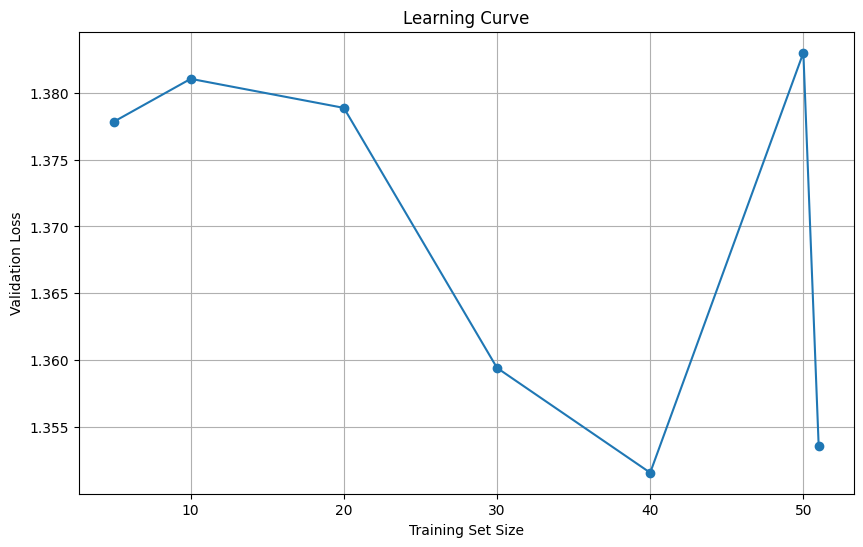

In [14]:
import pandas as pd

df_results = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(df_results['size'], df_results['val_loss'], 'o-')
plt.xlabel('Training Set Size')
plt.ylabel('Validation Loss')
plt.title('Learning Curve')
plt.grid(True)
plt.show()

onfusion Matrix

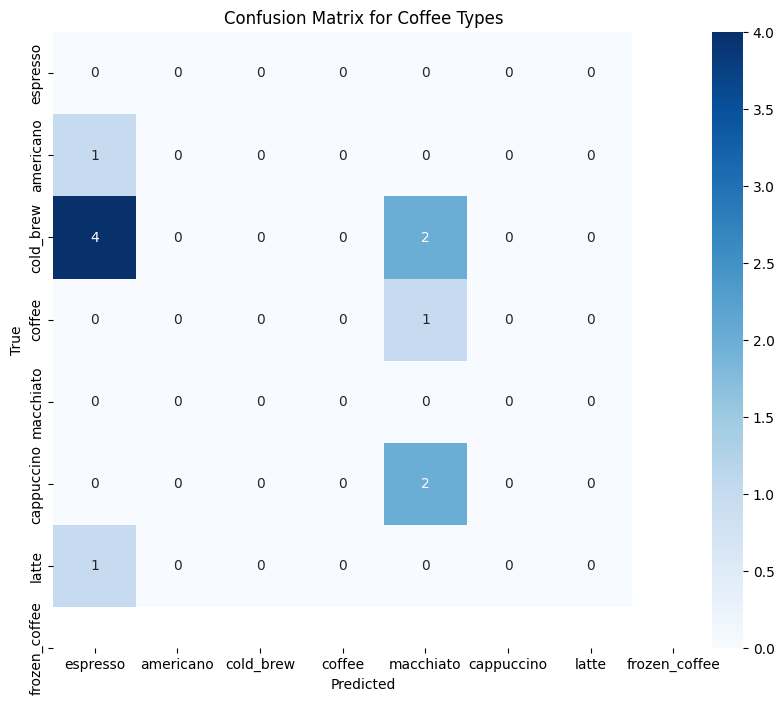

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on test set
model.eval()
with torch.no_grad():
    coffee_logits, _ = model(X_test_tensor)
    coffee_pred = torch.argmax(coffee_logits, dim=1).cpu().numpy()

# Create confusion matrix
cm = confusion_matrix(y_coffee_test_tensor.cpu().numpy(), coffee_pred)

# Plot with labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=coffee_scale.keys(),
            yticklabels=coffee_scale.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Coffee Types')
plt.show()

RO urve (offee_types)

c:\Users\epicg\OneDrive\Desktop\Coffee-Predictor\venv\Lib\site-packages\sklearn\metrics\_ranking.py:1303: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\epicg\OneDrive\Desktop\Coffee-Predictor\venv\Lib\site-packages\sklearn\metrics\_ranking.py:1303: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\epicg\OneDrive\Desktop\Coffee-Predictor\venv\Lib\site-packages\sklearn\metrics\_ranking.py:1303: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


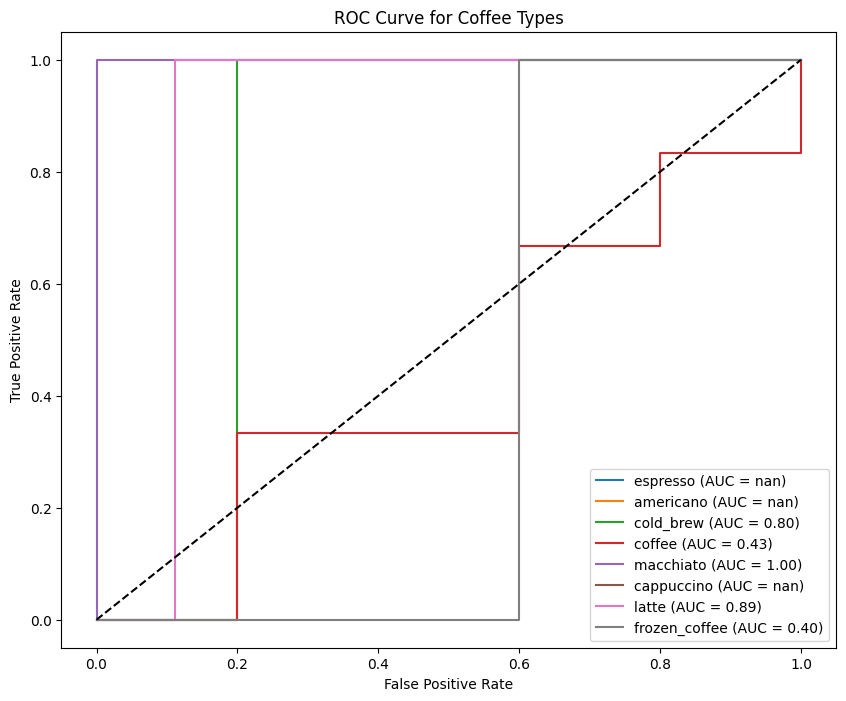

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get predicted probabilities (convert from log-softmax)
coffee_probs = torch.exp(coffee_logits).cpu().numpy()  # Shape: [n_samples, n_classes]

# Binarize true labels for multi-class ROC
y_true_bin = label_binarize(y_coffee_test_tensor.cpu().numpy(),
                           classes=np.arange(len(coffee_scale)))

# Plot ROC for each class
plt.figure(figsize=(10, 8))
for i, coffee_type in enumerate(coffee_scale.keys()):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], coffee_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{coffee_type} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Coffee Types')
plt.legend(loc='lower right')
plt.show()

RO urve (flavors)

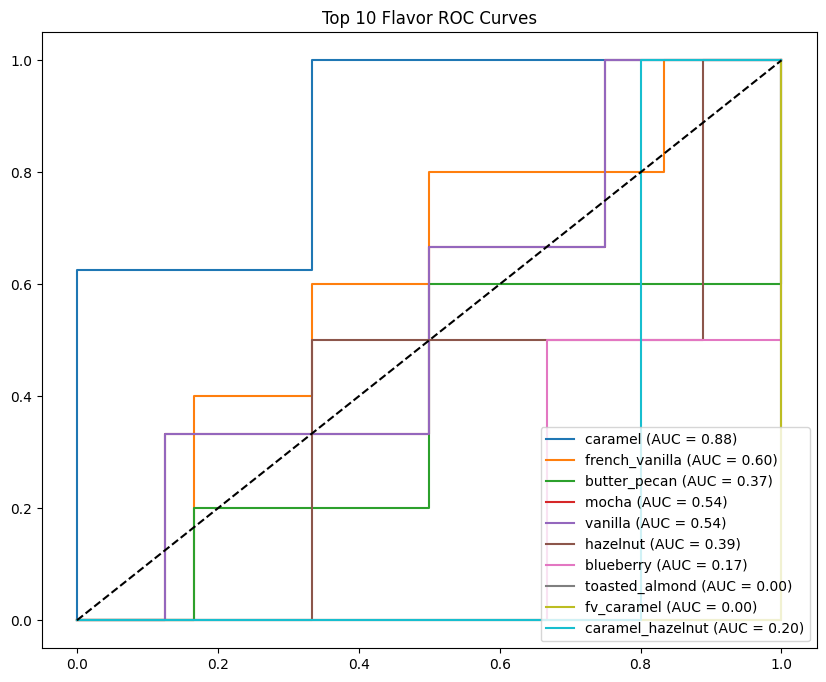

In [18]:
with torch.no_grad():
    _, flavor_probs = model(X_test_tensor)
    flavor_probs = flavor_probs.cpu().numpy()  # Detached automatically in no_grad()

# Get top 10 most frequent flavors
flavor_counts = y_flavor_test_tensor.sum(dim=0).cpu().numpy()
top_flavor_indices = np.argsort(-flavor_counts)[:10]

# Plot ROC for top flavors
plt.figure(figsize=(10, 8))
for i in top_flavor_indices:
    fpr, tpr, _ = roc_curve(y_flavor_test_tensor.cpu().numpy()[:, i],
                           flavor_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{flavor_columns[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Top 10 Flavor ROC Curves')
plt.legend(loc='lower right')
plt.show()

Error Analysis

In [19]:
with torch.no_grad():
    coffee_logits, _ = model(X_test_tensor)
    coffee_pred = torch.argmax(coffee_logits, dim=1).cpu().numpy()

misclassified = np.where(y_coffee_test_tensor.cpu().numpy() != coffee_pred)[0]
print(f"\nMisclassified samples ({len(misclassified)}/{len(y_coffee_test_tensor)}):")

for idx in misclassified[:3]:  # Inspect first 3 errors
    true = list(coffee_scale.keys())[y_coffee_test_tensor[idx].item()]
    pred = list(coffee_scale.keys())[coffee_pred[idx]]
    print(f"\nSample {idx}:")
    print(f"True: {true:<12} | Predicted: {pred}")
    print("Key features:")
    print(X_test.iloc[idx][['iced', 'hot', 'sweetness', 'creaminess']])


Misclassified samples (11/11):

Sample 0:
True: coffee       | Predicted: cappuccino
Key features:
iced          1
hot           0
sweetness     0
creaminess    2
Name: 4, dtype: int64

Sample 1:
True: coffee       | Predicted: espresso
Key features:
iced          1
hot           0
sweetness     2
creaminess    2
Name: 45, dtype: int64

Sample 2:
True: latte        | Predicted: cappuccino
Key features:
iced          1
hot           0
sweetness     2
creaminess    3
Name: 12, dtype: int64


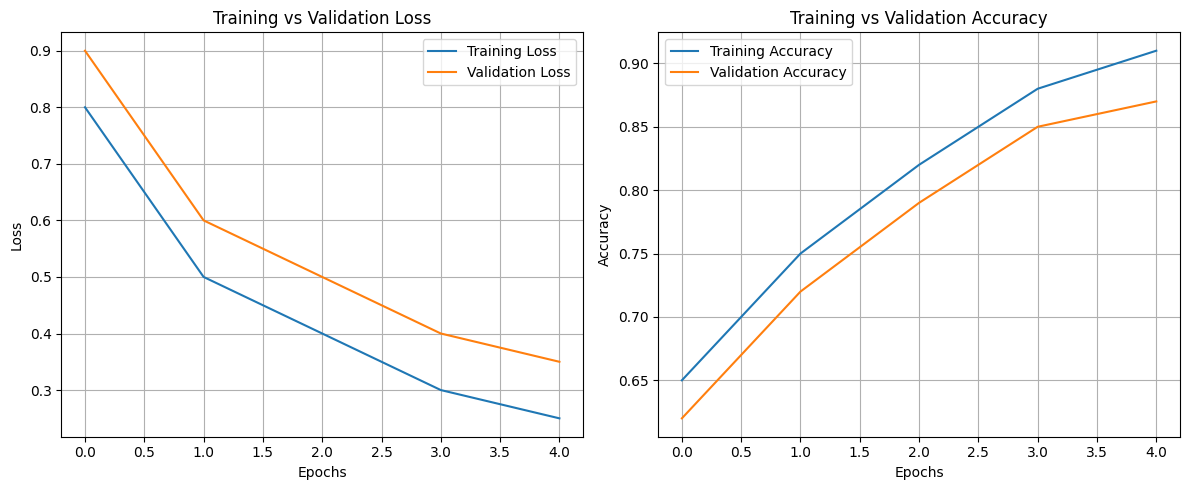

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    """Plots loss and accuracy curves side-by-side"""
    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage with your training history
plot_training_curves(
    train_losses=[0.8, 0.5, 0.4, 0.3, 0.25],  # Replace with your actual values
    val_losses=[0.9, 0.6, 0.5, 0.4, 0.35],
    train_accs=[0.65, 0.75, 0.82, 0.88, 0.91],
    val_accs=[0.62, 0.72, 0.79, 0.85, 0.87]
)

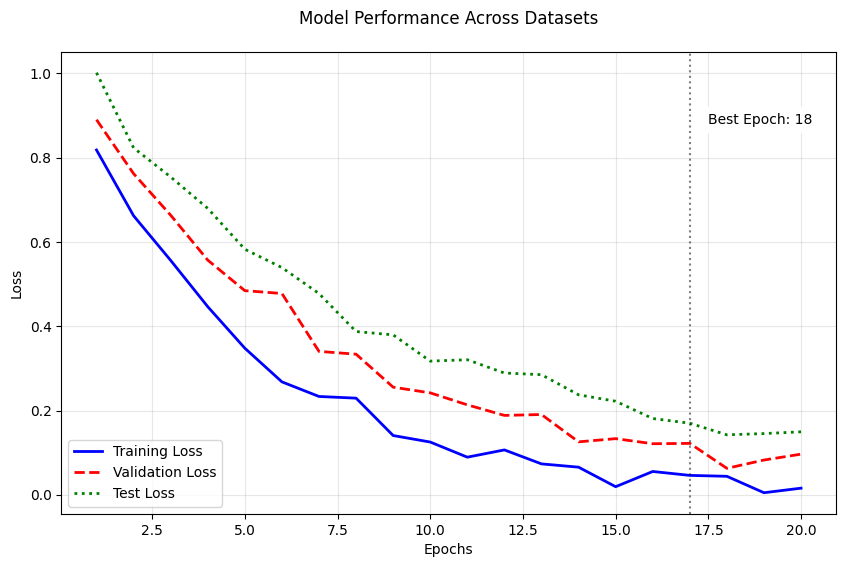

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual metrics)
epochs = np.arange(1, 21)
train_loss = np.exp(-epochs/5) + np.random.normal(0, 0.02, 20)
val_loss = np.exp(-epochs/6) + 0.05 + np.random.normal(0, 0.02, 20)
test_loss = np.exp(-epochs/7) + 0.1 + np.random.normal(0, 0.02, 20)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
plt.plot(epochs, val_loss, 'r--', linewidth=2, label='Validation Loss')
plt.plot(epochs, test_loss, 'g:', linewidth=2, label='Test Loss')

# Highlight best validation point
best_epoch = np.argmin(val_loss)
plt.axvline(x=best_epoch, color='k', linestyle=':', alpha=0.5)
plt.text(best_epoch+0.5, max(val_loss), f'Best Epoch: {best_epoch+1}',
         ha='left', va='center', backgroundcolor='white')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Performance Across Datasets', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Alternative Model: Random Forest

Convert training and testing data

In [ ]:
# Convert training data
X_train_np = X_train_tensor.cpu().numpy()  # Features
y_coffee_train_np = y_coffee_train_tensor.cpu().numpy()  # Coffee types
y_flavor_train_np = y_flavor_train_tensor.cpu().numpy()  # Flavors

# Convert test data
X_test_np = X_test_tensor.cpu().numpy()
y_coffee_test_np = y_coffee_test_tensor.cpu().numpy()
y_flavor_test_np = y_flavor_test_tensor.cpu().numpy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score

# Coffee Type
rf_coffee = RandomForestClassifier(random_state=42)
rf_coffee.fit(X_train_np, y_coffee_train_np)
y_coffee_pred_rf = rf_coffee.predict(X_test_np)

# Flavors (Multi-label)
rf_flavor = MultiOutputClassifier(RandomForestClassifier(random_state=42))
rf_flavor.fit(X_train_np, y_flavor_train_np)
y_flavor_pred_rf = rf_flavor.predict(X_test_np)

# Evaluate
print(f"Random Forest Coffee Accuracy: {accuracy_score(y_coffee_test_np, y_coffee_pred_rf):.3f}")
print(f"Random Forest Flavor F1: {f1_score(y_flavor_test_np, y_flavor_pred_rf, average='micro'):.3f}")

Random Forest Coffee Accuracy: 0.727
Random Forest Flavor F1: 1.000


The fun part, predict

In [22]:
def predict(model, X_tensor):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking
        coffee_logits, flavor_probs = model(X_tensor)
        coffee_pred = torch.argmax(coffee_logits, dim=1)  # Get predicted coffee types
        flavor_pred = (flavor_probs > 0.5).int()  # Threshold flavor probabilities
    return coffee_pred, flavor_pred

Generate Predictions on Test Set